<a href="https://colab.research.google.com/github/arghyadeep99/KhetiAI/blob/master/Plant_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch #v1.1.0
import PIL #v5.4.1
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch.optim import lr_scheduler
import copy
import json
import os
import shutil as st
from os.path import exists
from tqdm import tqdm

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [126]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [0]:
ls -lrt

In [0]:
cd drive/My Drive/PlantVillage

In [0]:
ls


In [0]:
'''src = "/content/drive/My Drive/PlantVillage/train/"
des = "/content/drive/My Drive/PlantVillage/testing/"
os.mkdir(des)
dirs = os.listdir(src)
print(len(os.listdir("/content/drive/My Drive/PlantVillage/train/Apple___healthy/")))
'''

In [0]:
'''import random
for dir in dirs :
  dir_src = src + dir + '/'
  dir_des = des + dir + '/'
  os.mkdir(dir_des)
  files = os.listdir(dir_src)
  no_of_files = int(len(files)*0.2)
  print("Before Split : " + dir_src + " : " + str(len(os.listdir(dir_src))))
  print("Before Split : " + dir_des + " : " + str(len(os.listdir(dir_des))))
  for i in range(no_of_files) :
    file = random.choice(files)
    st.move(dir_src + file,dir_des + file)
    files = os.listdir(dir_src)
  print("After Split : " + dir_src + " : " + str(len(os.listdir(dir_src))))
  print("After Split : " + dir_des + " : " + str(len(os.listdir(dir_des))))
'''

In [132]:
print(len(os.listdir("/content/drive/My Drive/PlantVillage/train/Apple___healthy/")))
print(len(os.listdir("/content/drive/My Drive/PlantVillage/testing/Apple___healthy/")))

1053
263


In [133]:
with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    print(cat_to_name)

{'Apple___Apple_scab': 'Apple___Apple_scab', 'Apple___Black_rot': 'Apple___Black_rot', 'Apple___Cedar_apple_rust': 'Apple___Cedar_apple_rust', 'Apple___healthy': 'Apple___healthy', 'Blueberry___healthy': 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew': 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy': 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_': 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight': 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy': 'Corn_(maize)___healthy', 'Grape___Black_rot': 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)': 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy': 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)': 'Orange___Haunglongbing_(Citrus

In [134]:
DATASET='/content/drive/My Drive/PlantVillage/'
TRAIN_DATA=DATASET+'train'
VAL_DATA=DATASET+'val'
TEST_DATA=DATASET+'testing'
Workers=4
batch_size=32
use_gpu = torch.cuda.is_available()

train_im = [len(f) for _,_,f in os.walk(TRAIN_DATA,topdown=True)]
test_im = [len(f) for _,_,f in os.walk(TEST_DATA,topdown=True)]
val_im = [len(f) for _,_,f in os.walk(VAL_DATA,topdown=True)]

print("Number of training samples: "+str(sum(train_im))) #44045
print("Number of testing samples: "+str(sum(test_im))) #32399
print("Number of validation samples: "+str(sum(val_im))) #11013

Number of training samples: 35252
Number of testing samples: 8793
Number of validation samples: 11014


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [136]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATASET, x),data_transforms[x]) for x in ['train', 'val','testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=Workers) for x in ['train', 'val','testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','testing']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 35252, 'val': 11014, 'testing': 8793}
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mit

In [0]:
model=models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
  
print(model)

In [0]:
from collections import OrderedDict

plant_classifier=nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
#Replacing the last layer of the pretrained model with our modifications.
model.fc=plant_classifier

In [0]:
#Model training function
train_loss,val_loss=[],[]
train_acc,val_acc=[],[]
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            train_loss.append(epoch_loss) if phase=='train' else val_loss.append(epoch_loss)
            train_acc.append(epoch_acc) if phase=='train' else val_acc.append(epoch_acc)
          
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [146]:
#This cell is for training, ensure connection is there before running this cell

num_epochs = 15
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Using GPU: True


In [0]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs)

In [0]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(frameon=True)
plt.show()

In [0]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'plants_disease_checkpoint.pth')

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('plants_disease_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [0]:
print(loaded_model)

In [0]:
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  step_for_print=20
  model.to(device)
  i=0
  
  for images, labels in dataloaders['testing']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    if i%step_for_print==0:
      print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['testing'])))
    i=i+1


In [0]:
test(loaded_model, dataloaders, device)

Testing Accuracy: 0.003
Testing Accuracy: 0.075
Testing Accuracy: 0.145
Testing Accuracy: 0.215
Testing Accuracy: 0.284
Testing Accuracy: 0.355
Testing Accuracy: 0.424
Testing Accuracy: 0.494
Testing Accuracy: 0.564
Testing Accuracy: 0.633
Testing Accuracy: 0.703
Testing Accuracy: 0.773
Testing Accuracy: 0.843
Testing Accuracy: 0.914


In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    probabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(probabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = probabilities[top_idx]

    return top_probability, top_class

In [161]:
print (predict('/content/drive/My Drive/PlantVillage/testing/Tomato___Early_blight/004cbe60-8ff9-4965-92df-e86694d5e9ba___RS_Erly.B 8253.JPG', loaded_model))

(array([9.8714483e-01, 1.1637378e-02, 1.1446401e-03, 3.8751452e-05,
       3.2523658e-05], dtype=float32), ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Pepper,_bell___Bacterial_spot', 'Tomato___Leaf_Mold'])


In [0]:
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

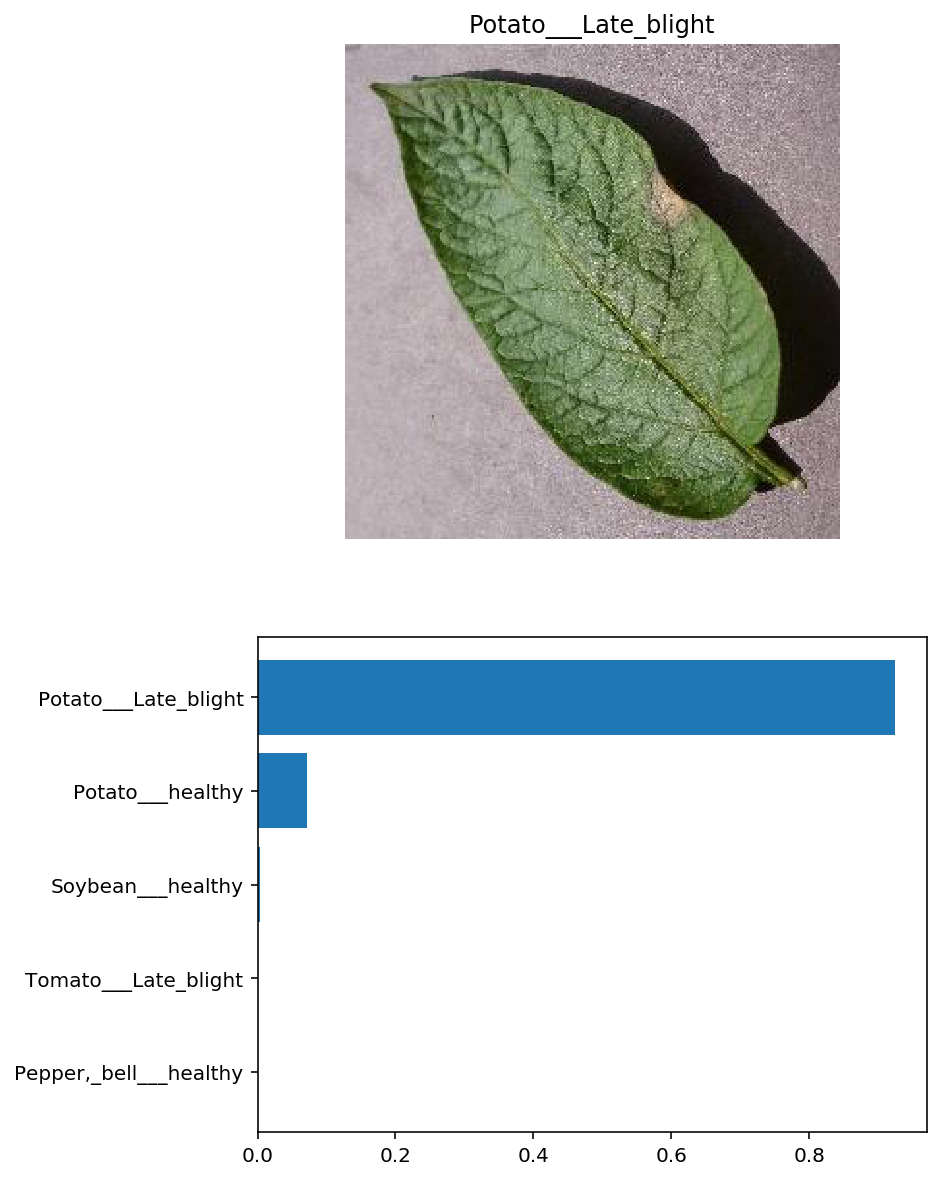

In [169]:
#img='/content/drive/My Drive/PlantVillage/testing/Tomato___Tomato_mosaic_virus/09910ece-e505-4e19-ae9b-0d9e2eaa2cb1___PSU_CG 2047.JPG'
#img='/content/drive/My Drive/PlantVillage/testing/Tomato___Septoria_leaf_spot/06225525-413e-411b-a503-85e8dc6050a8___JR_Sept.L.S 8351.JPG'
img='/content/drive/My Drive/PlantVillage/testing/Potato___Late_blight/0eb28ea9-c9e4-4999-9de2-835682241e53___RS_LB 2708.JPG'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)